# ResNet特征消融分析

同济子豪兄 

2022-7-11

## 导入工具包

In [38]:
import torch
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as T
from torchvision import transforms
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import numpy as np

import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

## 载入预训练Resnet模型

In [40]:
model = models.resnet18(pretrained=True)
model = model.eval()

## 载入ImageNet 1000图像分类标签

In [31]:
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [33]:
# idx_to_labels

## 载入输入图像及实例分割标注

In [34]:
# # 下载 Pascal VOC 2012数据集
# root = "./VOC"
# dataset = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='train', download=True, transform=None, target_transform=None)

# # 选出一张测试图像
# sample_ind = 91
# img_path = dataset.images[sample_ind]
# mask_path = dataset.masks[sample_ind]


In [35]:
img_path = 'img/VOC2012_demo/JPEGImages/2007_002953.jpg'
mask_path = 'img/VOC2012_demo/SegmentationClass/2007_002953.png'

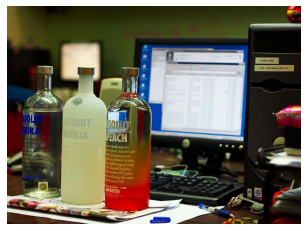

In [36]:
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

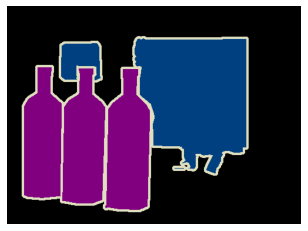

In [37]:
mask_img = Image.open(mask_path)
plt.imshow(mask_img)
plt.axis('off')
plt.show()

In [188]:
np.unique(mask_img)

array([  0,   5,  20, 255], dtype=uint8)

[0, 5, 20, 255]对应 VOC 数据集中的 background, bottle, tvmonitor void 四个类别。

## 预处理

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [48]:
input_img = transform(img).unsqueeze(0)

## 模型预测

In [50]:
pred_logits = model(input_img)

In [53]:
pred_softmax = F.softmax(pred_logits, dim=1)

In [254]:
def classify(img_path, n=5):
    '''
    输入图像路径，运行模型预测，输出结果
    '''
    img = Image.open(img_path) # 读取图像
    input_img = transform(img).unsqueeze(0) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做softmax
    plt.plot(pred_softmax.detach().numpy()[0])
    plt.show()
    
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    confs = top_n[0].detach().numpy().squeeze()
    label_ids = top_n[1].detach().numpy().squeeze()
    print('{:^18}{:^18}{:^18}{:^18}'.format('Class', 'Class_ID', 'Confidence(%)', 'WordNet'))
    for i in range(n):
        class_name = idx_to_labels[str(label_ids[i])][1] # 获取类别名称
        label_idx = label_ids[i] # 获取类别号
        wordnet = idx_to_labels[str(label_ids[i])][0] # 获取 WordNet
        confidence = confs[i] * 100 # 获取置信度
        print('{:^18}{:^18}{:^18.2f}{:^18}'.format(class_name, label_idx, confidence, wordnet)) # 格式化工整输出

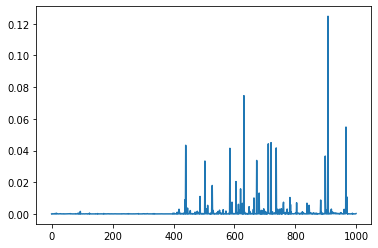

      Class            Class_ID       Confidence(%)        WordNet      
   wine_bottle           907              12.47           n04591713     
      lotion             631               7.46           n03690938     
     red_wine            966               5.48           n07892512     
   pill_bottle           720               4.50           n03937543     
     perfume             711               4.42           n03916031     
   beer_bottle           440               4.33           n02823428     
    pop_bottle           737               4.16           n03983396     
    hair_spray           585               4.14           n03476991     
   water_bottle          898               3.65           n04557648     
      mouse              673               3.37           n03793489     


In [255]:
classify('img/VOC2012_demo/JPEGImages/2007_002953.jpg', n=10)

## 最高置信度预测结果

In [182]:
pred_score, pred_label_idx = torch.topk(pred_softmax, 1)
pred_score = pred_score.squeeze_().item()
pred_label_idx = pred_label_idx.squeeze_().item()
pred_label = idx_to_labels[str(pred_label_idx)]

In [183]:
pred_score

0.12470876425504684

In [184]:
pred_label_idx

907

In [185]:
pred_label

['n04591713', 'wine_bottle']

提示：图像分类假设图中仅有一个物体，如果有多个类别的多个物体，会略微干扰预测结果。

## feature group 特征分组

在实例分割标注图中，每一个类别都被划为一类 feature group。

Feature Ablation 就是分析每个 feature group 存在（或者不存在）的影响。

In [195]:
# 将实例分割标注图像转为 count, channels, height, width 维度
feature_mask = np.array(mask_img.getdata()).reshape(1, 1, mask_img.size[1], mask_img.size[0])

In [196]:
feature_mask.shape

(1, 1, 370, 500)

In [197]:
np.unique(feature_mask)

array([  0,   5,  20, 255])

In [198]:
# 将实例分割标注图转为从 1 开始的标注值（而不是 0-255 的256个标注值），便于后续处理。
feature_mask[feature_mask == 5] = 1 # bottle
feature_mask[feature_mask == 20] = 2 # tvmonitor
feature_mask[feature_mask == 255] = 3 # void

In [199]:
np.unique(feature_mask)

array([0, 1, 2, 3])

## Feature Ablation 可解释性分析

In [200]:
ablator = FeatureAblation(resnet)

In [205]:
# 计算每个 feature group 对模型预测为 wine_bottle 概率的影响
attribution_map = ablator.attribute(
    input_img,
    target=pred_label_idx,
    feature_mask=torch.tensor(feature_mask))
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
attribution_map = np.transpose(attribution_map, (1,2,0))

In [206]:
attribution_map.shape

(370, 500, 3)

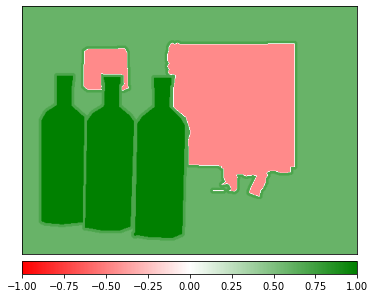

In [207]:
viz.visualize_image_attr(attribution_map,
                         method="heat_map",
                         sign="all",
                         show_colorbar=True)
plt.show()

从图中可以看出，绿色最深的区域为酒瓶对应的区域，证明酒瓶区域对模型预测为 wine_bottle 的影响最大，如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生较大负面影响。

背景区域的影响较小。如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生较小负面影响。

显示器区域为红色，如果抹掉该区域，会对模型预测为 wine_bottle 的概率产生正面积极影响。

## 更换类别为 tv_monitor（664）

In [208]:
attribution_map = ablator.attribute(
    input_img,
    target=664,
    feature_mask=torch.tensor(feature_mask))
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
attribution_map = np.transpose(attribution_map, (1,2,0))

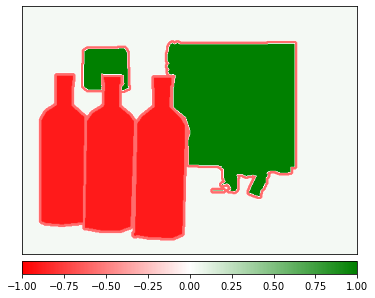

In [210]:
viz.visualize_image_attr(attribution_map,
                         method="heat_map",
                         sign="all",
                         show_colorbar=True)
plt.show()

从图中可以看出，绿色最深的区域为显示器对应的区域，证明显示器区域对模型预测为 tv_monitor 的影响最大，如果抹掉该区域，会对模型预测为 tv_monitor 的概率产生较大负面影响。

背景区域的影响较小。如果抹掉该区域，影响较小。

酒瓶区域 和 边缘区域 为红色，如果抹掉该区域，会对模型预测为 tv_monitor 的概率产生正面积极影响。

思考：边缘区域为什么是红色？

## Sanity check 抹掉酒瓶和边缘区域

In [244]:
import cv2

In [252]:
new_mask = np.array(feature_mask)
new_mask[feature_mask == 0] = 1 # wine_bottle
new_mask[feature_mask == 1] = 0 # 背景
new_mask[feature_mask == 2] = 1 # tv_monitor
new_mask[feature_mask == 3] = 0 # 边缘
new_mask = np.expand_dims(new_mask.squeeze(), axis=2).astype(np.uint8)

img_without_bottles = cv2.bitwise_and(np.array(img), np.array(img), mask=new_mask)
img_without_bottles = cv2.cvtColor(img_without_bottles, cv2.COLOR_BGR2RGB)

cv2.imwrite('img_without_bottles.jpg', img_without_bottles)

True

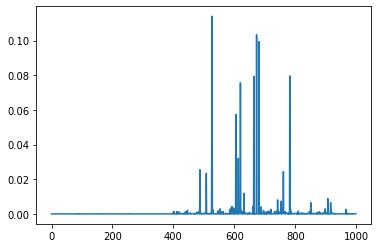

      Class            Class_ID       Confidence(%)        WordNet      
 desktop_computer        527              11.41           n03180011     
      mouse              673              10.33           n03793489     
     notebook            681               9.94           n03832673     
      screen             782               7.96           n04152593     
     monitor             664               7.94           n03782006     
      laptop             620               7.56           n03642806     
       desk              526               6.66           n03179701     
       iPod              605               5.74           n03584254     
     joystick            613               3.22           n03602883     
cellular_telephone       487               2.55           n02992529     


In [258]:
classify('img_without_bottles.jpg', n=10)